In [1]:
from dataset_generator_2 import Dataset_sat
import numpy as np
from image_utils import standardize
import matplotlib.pyplot as plt
from scipy.ndimage.morphology import distance_transform_bf
from torch.utils.data import DataLoader
import torch
from unet_val_2 import UNet
import torch.backends.cudnn as cudnn
import torch.nn.functional as Fu
import torch.nn as nn
from torch.autograd import Variable

/home/s161362/.conda/envs/env_dhi/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# PATH_TEST='../DATA_GHANA/DATASET/120_x_120_8_bands/TEST/'
PATH_TEST='/scratch/SPACENET_DATA_PROCESSED/DATASET/120_x_120_8_bands_pansh/TEST/'
test_size=20



    
test_generator = Dataset_sat.from_root_folder(PATH_TEST,2,max_data_size=100)
test_loader = DataLoader(test_generator, batch_size=test_size,shuffle=True, num_workers=1)
sample_test=next(iter(test_loader))
X_test=sample_test['input']
Y_test=sample_test['groundtruth']
X_test=standardize(X_test)


image 0


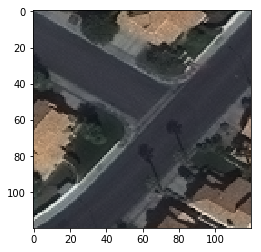

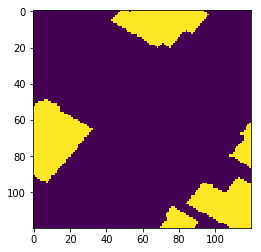

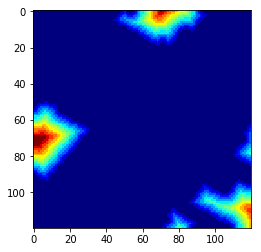

image 1


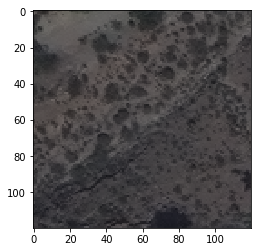

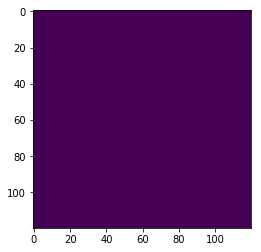

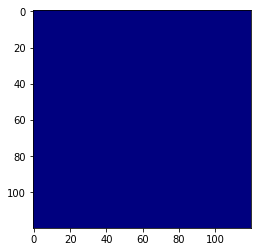

image 2


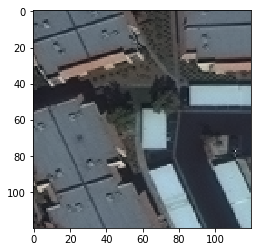

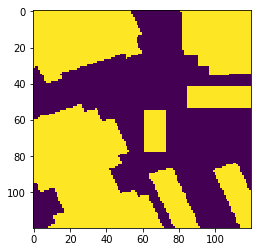

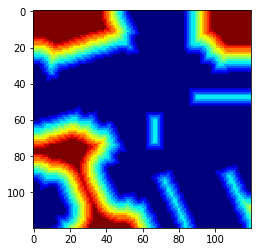

image 3


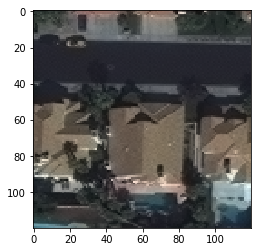

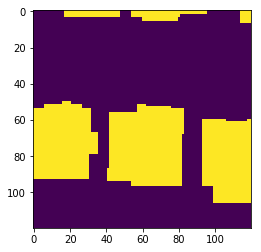

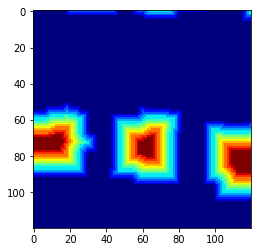

image 4


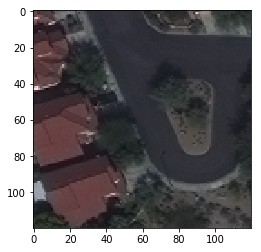

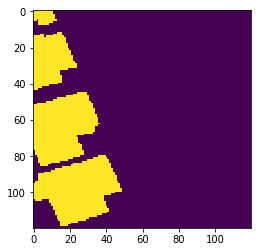

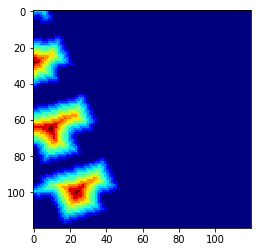

image 5


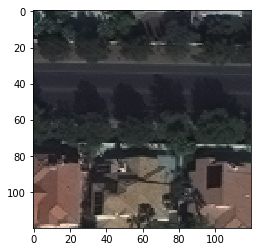

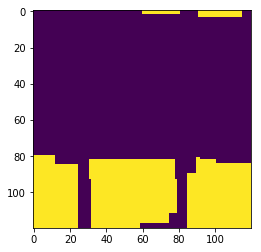

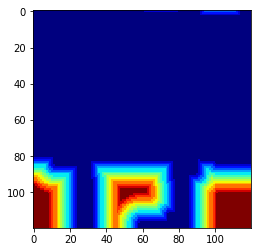

image 6


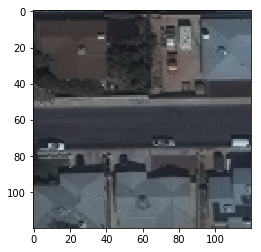

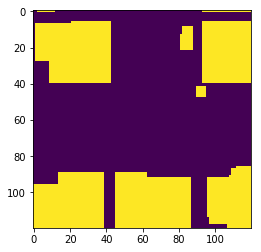

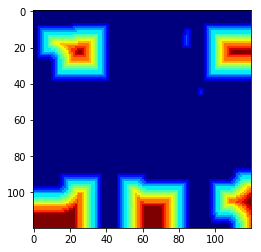

image 7


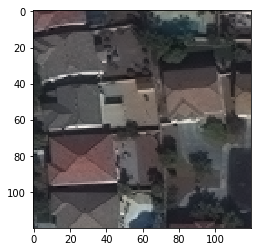

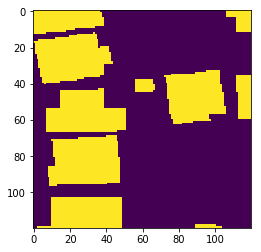

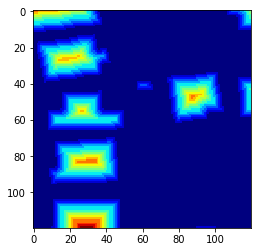

image 8


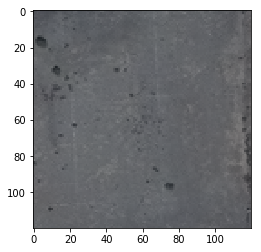

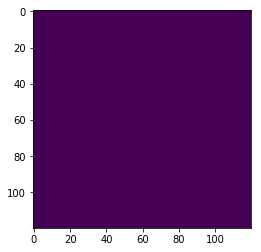

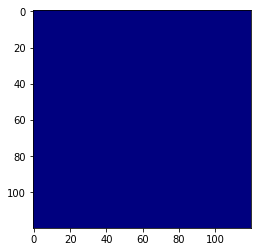

image 9


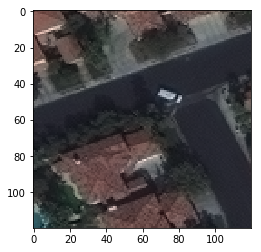

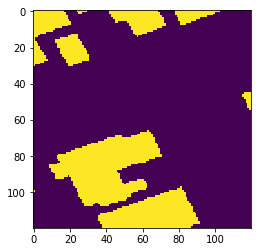

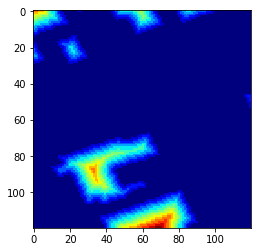

image 10


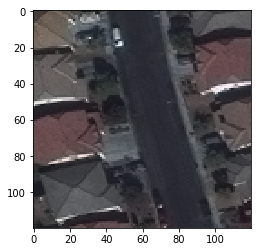

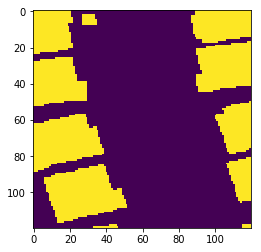

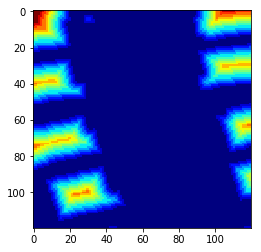

image 11


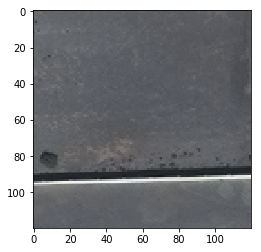

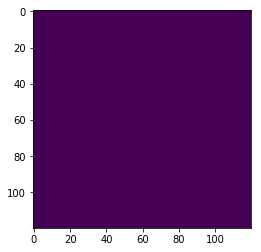

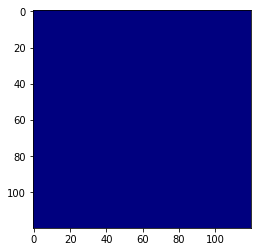

image 12


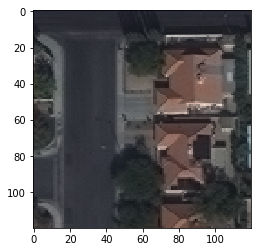

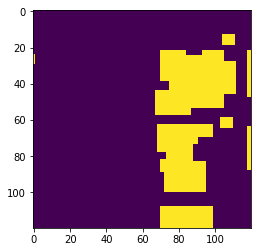

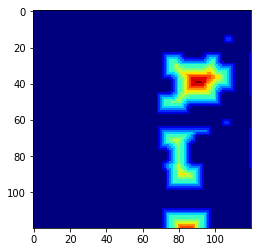

image 13


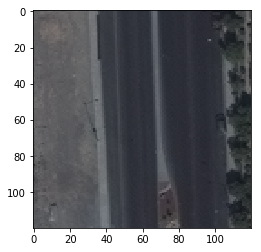

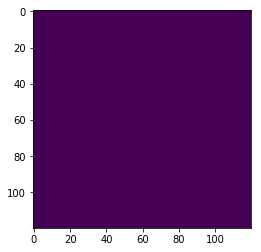

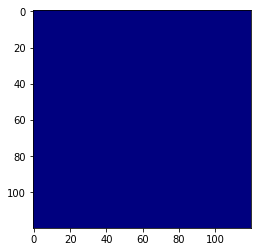

image 14


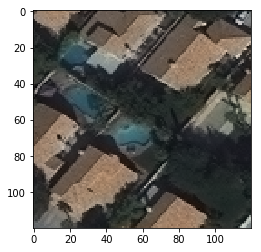

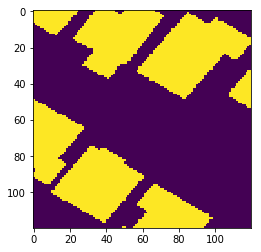

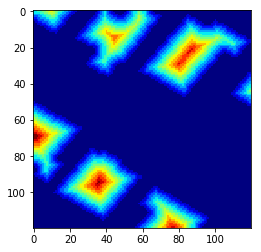

image 15


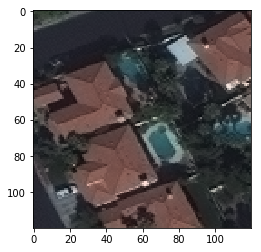

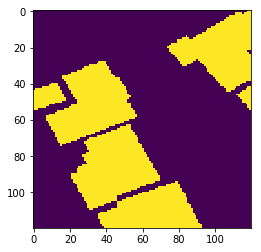

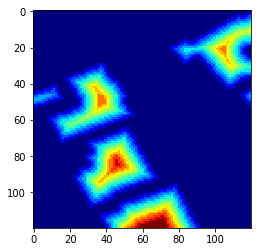

image 16


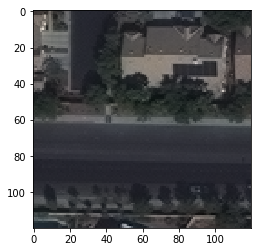

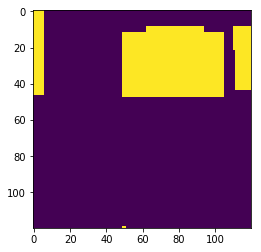

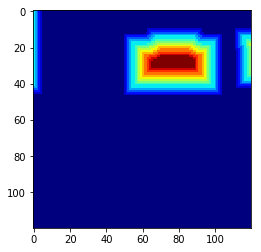

image 17


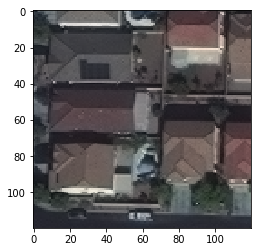

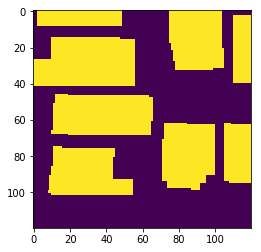

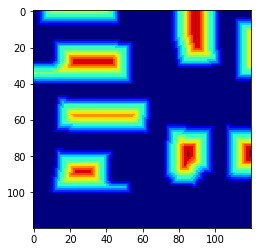

image 18


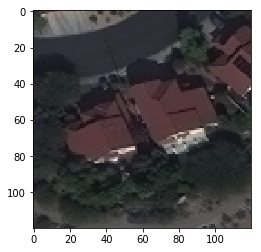

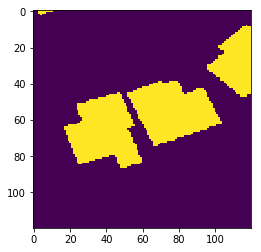

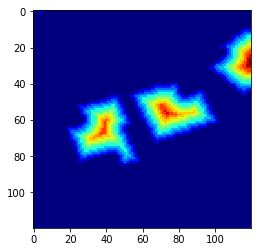

image 19


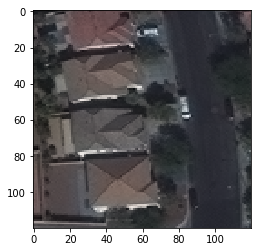

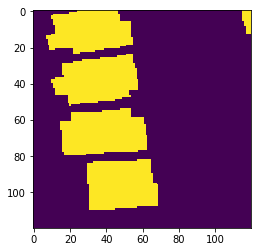

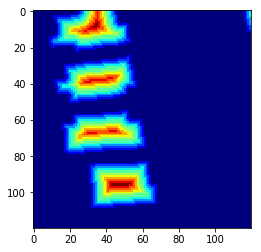

In [4]:
K=15
T=33

for i in range(test_size): 
    print('image %d'%i)
    indexes=[5,3,2]
    
    plt.imshow(np.transpose(np.asarray(X_test)[i,:,:,indexes],(1,2,0)))
    plt.show()
    plt.imshow(np.asarray(Y_test)[i,:,:,1])
    plt.show()
    distance=distance_transform_bf(np.asarray(Y_test)[i,:,:,1],sampling=2)
    test=np.minimum(distance,T*(distance>0))*(K-1)/T
    inp=torch.LongTensor(test)
    inp_ = torch.unsqueeze(inp, len(test.shape))
    one_hot = torch.FloatTensor(test.shape[0], test.shape[1], K).zero_()
    one_hot.scatter_(len(test.shape), inp_, 1)
    plt.imshow(np.argmax(one_hot,axis=2),cmap="jet")
    plt.show()

In [9]:
def distance_map(Y,threshold=20,bins=15):
    list_one_hot=[]
    for i in range(len(Y)):
        distance=distance_transform_bf(np.asarray(Y_test)[i,:,:,1],sampling=2)
        distance=np.minimum(distance,T*(distance>0))*(K-1)/T
        inp=torch.LongTensor(distance)
        inp_ = torch.unsqueeze(inp, len(distance.shape))
        one_hot = torch.FloatTensor(distance.shape[0],distance.shape[1], K).zero_()
        one_hot.scatter_(len(distance.shape), inp_, 1)
        one_hot=np.asarray(one_hot)
        list_one_hot.append(one_hot)
 
    list_one_hot=np.asarray(list_one_hot)
    return list_one_hot
    

(20, 120, 120, 15)


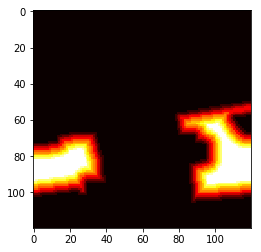

In [21]:
test=distance_map(Y_test)
print(test.shape)
plt.imshow(np.argmax(test[1],axis=2),cmap="hot")
plt.show()

0.7231664061546326


/home/s161362/.conda/envs/env_dhi/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:180: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.")


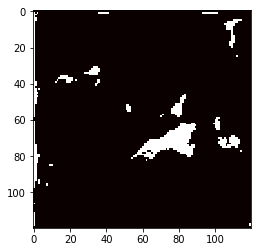

0.7740095853805542


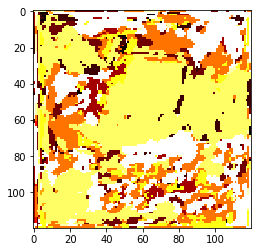

In [7]:

INPUT_CHANNELS=9
NB_CLASSES=2
DEFAULT_LAYERS=3
DEFAULT_FEATURES_ROOT=32
DROPOUT=0.9#0.9

model=UNet(INPUT_CHANNELS,NB_CLASSES,DEFAULT_LAYERS,DEFAULT_FEATURES_ROOT,DROPOUT,distance_net=True)
model.cuda()
cudnn.benchmark = True

batch_x=X_val
batch_y=Y_val


X=np.transpose(batch_x, axes=[0,3,1,2])
X = torch.FloatTensor(X)
X = Variable(X).cuda()

Y=np.transpose(batch_y, axes=[0,3,1,2])
Y = torch.FloatTensor(Y)
Y = Variable(Y).cuda()

Y_dist=distance_map(batch_y)
Y_dist=np.transpose(Y_dist, axes=[0,3,1,2])
Y_dist = torch.FloatTensor(Y_dist)
Y_dist = Variable(Y_dist).cuda()

y_pred_dist,y_pred_seg=model(X)
probs_dist = Fu.softmax(y_pred_dist,dim=1)
prob_seg = Fu.softmax(y_pred_seg,dim=1)

loss_dist=Fu.binary_cross_entropy_with_logits(probs_dist,Y_dist)
loss_seg=Fu.binary_cross_entropy_with_logits(prob_seg,Y)

probs_dist=probs_dist.data.cpu().numpy()
probs_dist=np.transpose(probs_dist, axes=[0,2,3,1])

prob_seg=prob_seg.data.cpu().numpy()
prob_seg=np.transpose(prob_seg, axes=[0,2,3,1])

print(loss_dist.data[0])
plt.imshow(np.argmax(prob_seg[2],axis=2),cmap="hot")
plt.show()

print(loss_seg.data[0])
plt.imshow(np.argmax(probs_dist[2],axis=2),cmap="hot")
plt.show()
